In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,8]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Thesis datasets/Monthly_Pharmaceutical_Sales.csv')
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


In [5]:
df.tail()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
65,2019-06-30,151.54,101.627,103.20,610.00,193.0,25.0,142.0,156.04
66,2019-07-31,181.00,103.541,92.80,649.80,250.6,20.0,115.0,105.20
67,2019-08-31,181.91,88.269,84.20,518.10,237.0,26.0,145.0,97.30
68,2019-09-30,161.07,111.437,93.50,984.48,227.8,16.0,161.0,109.10
69,2019-10-31,44.37,37.300,20.65,295.15,86.0,7.0,37.0,11.13


In [6]:
df.shape

(70, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   datum   70 non-null     object 
 1   M01AB   70 non-null     float64
 2   M01AE   70 non-null     float64
 3   N02BA   70 non-null     float64
 4   N02BE   70 non-null     float64
 5   N05B    70 non-null     float64
 6   N05C    70 non-null     float64
 7   R03     70 non-null     float64
 8   R06     70 non-null     float64
dtypes: float64(8), object(1)
memory usage: 5.0+ KB


In [8]:
time = pd.date_range(start='1/31/2014',periods=70,freq='M')
df['time_stamp'] = pd.DataFrame(time)
df.drop('datum',axis=1,inplace=True)
df = df.set_index('time_stamp')

In [9]:
df.head()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
time_stamp,,,,,,,,
2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


In [10]:
df.tail()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
time_stamp,,,,,,,,
2019-06-30,151.54,101.627,103.20,610.00,193.0,25.0,142.0,156.04
2019-07-31,181.00,103.541,92.80,649.80,250.6,20.0,115.0,105.20
2019-08-31,181.91,88.269,84.20,518.10,237.0,26.0,145.0,97.30
2019-09-30,161.07,111.437,93.50,984.48,227.8,16.0,161.0,109.10
2019-10-31,44.37,37.300,20.65,295.15,86.0,7.0,37.0,11.13


In [11]:
df = df[['N02BE']]
df

,N02BE
time_stamp,
2014-01-31,878.030
2014-02-28,1001.900
2014-03-31,779.275
2014-04-30,698.500
2014-05-31,628.780
...,...
2019-06-30,610.000
2019-07-31,649.800
2019-08-31,518.100


In [12]:
df = df + 1

In [13]:
df

,N02BE
time_stamp,
2014-01-31,879.030
2014-02-28,1002.900
2014-03-31,780.275
2014-04-30,699.500
2014-05-31,629.780
...,...
2019-06-30,611.000
2019-07-31,650.800
2019-08-31,519.100


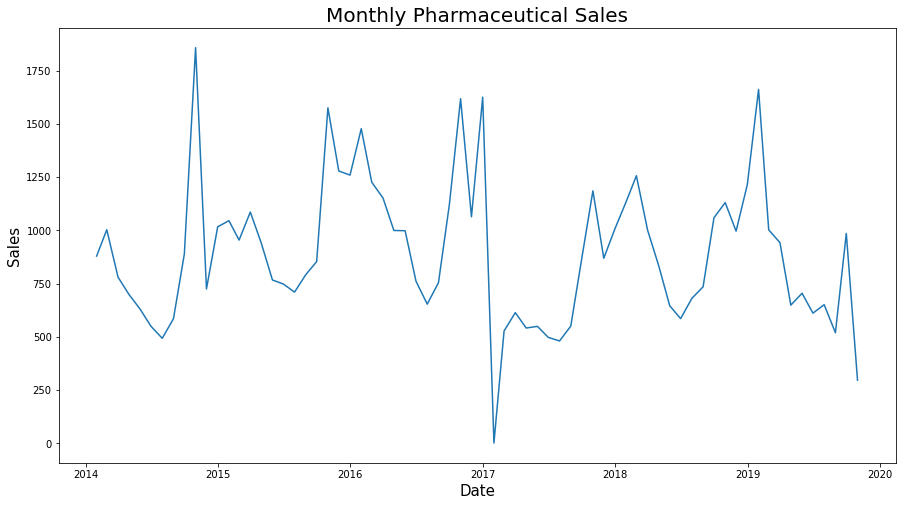

In [14]:
plt.plot(df)
plt.title('Monthly Pharmaceutical Sales',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Sales',fontsize=15)
plt.show()

In [15]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [58]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['N02BE'] = df['N02BE'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [59]:
#Split data set into testing dataset and train dataset
train_size = 56
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 2
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
# reshape input to be [samples, window size, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(54, 1, 2)
(54,)
(12, 1, 2)
(12,)


In [19]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 8.4 MB/s 


In [56]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,SimpleRNN,Dropout,Bidirectional
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [21]:
def build_model(hp):
    model = keras.Sequential()
    model.add(SimpleRNN(hp.Int('rnn_layer_1',min_value=32,max_value=256,step=32), activation="relu",return_sequences=True, input_shape=(1,look_back),recurrent_dropout = hp.Choice("recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(SimpleRNN(hp.Int(f'rnn_{i}_units',min_value=32,max_value=256,step=32),activation="relu", return_sequences=True,recurrent_dropout = hp.Choice("recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    model.add(SimpleRNN(hp.Int('final_rnn_layer',min_value=32,max_value=256,step=32),activation="relu",recurrent_dropout = hp.Choice("recurrent_dropout",[0.2,0.4,0.6],default=0.4) ))
    model.add(Dense(hp.Int('dense_layer_1',min_value=32,max_value=256,step=32),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling="log")),
        loss='mae',
        metrics=['mae'])
    return model

In [23]:
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=1,
    directory='project',
    project_name='pharma Sales')

In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
rnn_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
rnn_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
final_rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': None, 'sampling': 'lo

In [25]:
tuner.search(trainX, trainY,
             epochs=500,
             batch_size=35,
             validation_data=(testX, testY))

Trial 20 Complete [00h 00m 41s]
val_mae: 0.09804630279541016

Best val_mae So Far: 0.09572657197713852
Total elapsed time: 00h 11m 29s
INFO:tensorflow:Oracle triggered exit


In [26]:
tuner.results_summary()

Results summary
Results in project/pharma Sales
Showing 10 best trials
Trial summary
Hyperparameters:
rnn_layer_1: 160
recurrent_dropout: 0.4
n_layers: 3
rnn_0_units: 160
final_rnn_layer: 160
dense_layer_1: 96
Dropout_rate: 0.2
learning_rate: 0.021779168728807242
rnn_1_units: 32
rnn_2_units: 64
rnn_3_units: 96
rnn_4_units: 224
rnn_5_units: 32
Score: 0.09572657197713852
Trial summary
Hyperparameters:
rnn_layer_1: 224
recurrent_dropout: 0.4
n_layers: 3
rnn_0_units: 160
final_rnn_layer: 160
dense_layer_1: 192
Dropout_rate: 0.1
learning_rate: 0.020576175937476363
rnn_1_units: 224
rnn_2_units: 96
rnn_3_units: 96
rnn_4_units: 96
rnn_5_units: 128
rnn_6_units: 64
rnn_7_units: 192
Score: 0.09707774966955185
Trial summary
Hyperparameters:
rnn_layer_1: 224
recurrent_dropout: 0.6
n_layers: 6
rnn_0_units: 128
final_rnn_layer: 96
dense_layer_1: 32
Dropout_rate: 0.30000000000000004
learning_rate: 0.008657947905507467
rnn_1_units: 192
rnn_2_units: 256
rnn_3_units: 192
rnn_4_units: 192
rnn_5_units: 128

In [27]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(1, 12))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 160)            26080     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 160)            51360     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1, 32)             6176      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1, 64)             6208      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 160)               36000     
                                                                 
 dense (Dense)               (None, 96)                15456     
                                                                 
 dropout (Dropout)           (None, 96)                0

In [29]:
from tensorflow.keras import optimizers

In [61]:
model = Sequential()
model.add(SimpleRNN(32,activation='relu',input_shape=(1,look_back),return_sequences=True))
model.add(SimpleRNN(16,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.00011779168728807242)
model.compile(optimizer = ad, loss = 'mae', metrics = ['mae'])
model_history=model.fit(trainX, trainY,validation_data=(testX, testY), batch_size = 35, epochs = 1000)

Epoch 1/1000
2/2 [==============================] - 2s 287ms/step - loss: 0.7416 - mae: 0.7416 - val_loss: 0.7215 - val_mae: 0.7215
Epoch 2/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.7380 - mae: 0.7380 - val_loss: 0.7178 - val_mae: 0.7178
Epoch 3/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.7344 - mae: 0.7344 - val_loss: 0.7141 - val_mae: 0.7141
Epoch 4/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.7307 - mae: 0.7307 - val_loss: 0.7104 - val_mae: 0.7104
Epoch 5/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.7271 - mae: 0.7271 - val_loss: 0.7068 - val_mae: 0.7068
Epoch 6/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.7234 - mae: 0.7234 - val_loss: 0.7031 - val_mae: 0.7031
Epoch 7/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.7197 - mae: 0.7197 - val_loss: 0.6994 - val_mae: 0.6994
Epoch 8/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.7160 - 

In [62]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [63]:
trainX_2 = scaler.inverse_transform(trainX.reshape(-1,3))
trainY_2 = scaler.inverse_transform([trainY])
testX_2 = scaler.inverse_transform(testX.reshape(-1,3))
testY_2 = scaler.inverse_transform([testY])

Train MAE: 194.4573187860867
Test MAE: 222.32704459663955


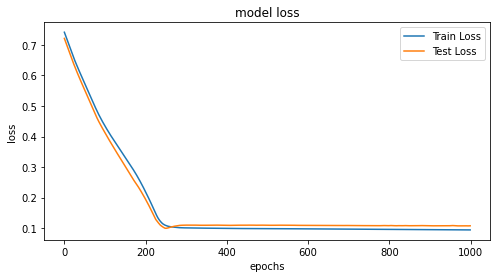

In [64]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print("Train MAE:",mae(trainY.reshape(-1,),train_predict.reshape(-1,)))
print("Test MAE:",mae(testY.reshape(-1,),test_predict.reshape(-1,)))
model_loss(model_history)

In [53]:
import seaborn as sns

In [65]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(54,66)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

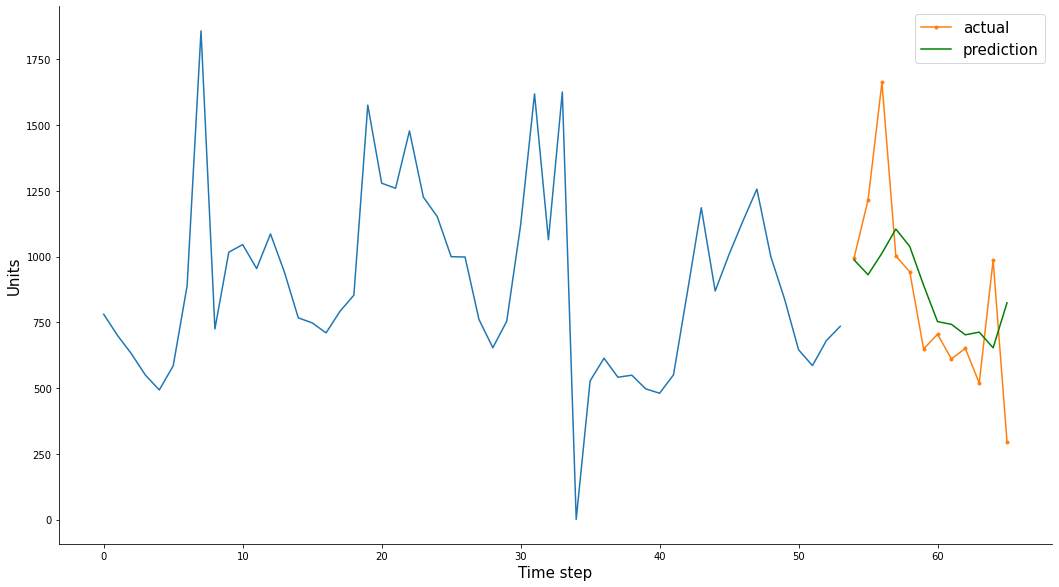

In [66]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)